In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyprojroot import here
import json
import torch

def plot_metrics_advanced(datasets_data, dataset_labels=None, xlabel="Number of Steps", 
                         mmd_metrics=None, title_prefix="", single_dataset=False):
    """
    Advanced plotting function that can handle both single and multiple datasets.
    
    Args:
        datasets_data: List of DataFrames (for multiple datasets) or single DataFrame (for single dataset)
        dataset_labels: List of labels for datasets (ignored for single dataset)
        xlabel: Label for x-axis
        mmd_metrics: List of MMD metric names to plot
        title_prefix: Prefix for plot titles
        single_dataset: Whether plotting a single dataset (True) or multiple datasets (False)
    
    Returns:
        The matplotlib figure object
    """
    
    if mmd_metrics is None:
        mmd_metrics = ["orbit_mmd", "degree_mmd", "spectral_mmd", "clustering_mmd", "gin_mmd"]
    
    # Set up color scheme
    sns.set_palette("colorblind")
    colors = sns.color_palette("colorblind")
    descriptor_colors = {
        "orbit": colors[0],
        "degree": colors[1],
        "spectral": colors[2],
        "clustering": colors[3],
        "gin": colors[4],
    }
    
    # Handle single dataset case
    if single_dataset:
        if not isinstance(datasets_data, list):
            datasets_data = [datasets_data]
        if dataset_labels is None:
            dataset_labels = [""]
        else:
            dataset_labels = [dataset_labels] if not isinstance(dataset_labels, list) else dataset_labels[:1]
    
    n_datasets = len(datasets_data)
    
    # Create subplot layout
    if single_dataset:
        # For single dataset: horizontal layout with 3 columns
        fig, axes = plt.subplots(1, 3, figsize=(10, 2))
        axes = axes.flatten()
        bottom_margin = 0.22
        legend_y = -0.04
    else:
        # For multiple datasets: 3x3 grid
        fig, axes = plt.subplots(n_datasets, 3, figsize=(10, len(datasets_data) * 1.8))
        bottom_margin = 0.15
        legend_y = -0.02

        if n_datasets == 1:
            axes = axes.reshape(1, -1)
    
    # Create legend elements
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], color="#7e9ef7", lw=2, label="Validity"))
    legend_elements.append(plt.Line2D([0], [0], color="black", lw=2, label="PolyGraphScore"))
    for metric in mmd_metrics:
        color = next((color for key, color in descriptor_colors.items() if key in metric), "black")
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=2, 
                                        label=metric.replace("_mmd", "").title() + " RBF"))

    for i, (data, label) in enumerate(zip(datasets_data, dataset_labels)):
        # Add dataset label for multiple datasets
        if not single_dataset and label:
            fig.text(-0.01, 0.83 - (i * 0.315), label, 
                     rotation=90, verticalalignment='center', fontsize=12, fontweight='bold')
        
        # Get axes for this dataset
        if single_dataset:
            ax_validity, ax_polyscore, ax_mmd = axes[0], axes[1], axes[2]
        else:
            ax_validity, ax_polyscore, ax_mmd = axes[i, 0], axes[i, 1], axes[i, 2]
        
        # Column 0: Validity
        ax_validity.plot(data["num_steps"], data["validity"], color="#7e9ef7")
        ax_validity.set_ylabel("Validity")
        ax_validity.set_ylim([0, 1])
        ax_validity.yaxis.set_major_locator(plt.MaxNLocator(6))
        if i == 0:
            ax_validity.set_title(f"{title_prefix}Validity" if title_prefix else "Validity")
        if i == n_datasets - 1:
            ax_validity.set_xlabel(xlabel)
        
        # Column 1: PolyScore
        ax_polyscore.plot(data["num_steps"], data["polyscore"], color="black")
        ax_polyscore.set_ylabel("PGS")
        ax_polyscore.set_ylim([0, 1])
        ax_polyscore.yaxis.set_major_locator(plt.MaxNLocator(6))
        if i == 0:
            ax_polyscore.set_title(f"{title_prefix}PolyGraphScore" if title_prefix else "PolyGraphScore")
        if i == n_datasets - 1:
            ax_polyscore.set_xlabel(xlabel)
        
        # Column 2: Combined MMD plots with multiple y-axes
        axes_list = []
        
        # Create y-axes for each MMD metric
        for j in range(len(mmd_metrics)):
            if j == 0:
                ax_twin = ax_mmd.twinx()
                ax_twin.spines['right'].set_position(('outward', 0))
            else:
                ax_twin = ax_mmd.twinx()
                ax_twin.spines['right'].set_position(('outward', 35 * j))
            axes_list.append(ax_twin)
        
        # Hide the main axis ticks and labels since we're not using it
        ax_mmd.set_yticks([])
        ax_mmd.set_ylabel("MMD²")
        ax_mmd.spines['left'].set_visible(False)
        
        # Plot each MMD metric on its own y-axis with scientific notation
        for j, metric in enumerate(mmd_metrics):
            color = next((color for key, color in descriptor_colors.items() if key in metric), "black")
            
            # Get the data for this metric
            metric_data = data[metric]
            
            # Calculate the scale factor (power of 10)
            max_val = metric_data.max()
            if max_val > 0:
                power = int(np.floor(np.log10(max_val)))
                scale_factor = 10 ** power
                
                # Scale the data
                scaled_data = metric_data / scale_factor
                
                # Plot the scaled data
                line, = axes_list[j].plot(data["num_steps"], scaled_data, color=color)
                axes_list[j].tick_params(axis='y', labelcolor=color)
                axes_list[j].yaxis.set_major_locator(plt.MaxNLocator(6))
                
                x_offset = 1.02 + (j * 0.28)
                axes_list[j].text(x_offset, 1.2, f'$\\times 10^{{{power}}}$',
                                transform=axes_list[j].transAxes,
                                color=color, fontsize=8,
                                verticalalignment='top',
                                horizontalalignment='left')
                #x_offset = 1.02 + (j * 0.28)
                #axes_list[j].text(x_offset, 1.2, f'$\\times 10^{{{power}}}$', 
                #                transform=axes_list[j].transAxes,
                #                color=color, fontsize=8, 
                #                verticalalignment='top',
                #                horizontalalignment='left')
            else:
                # Fallback for zero data
                line, = axes_list[j].plot(data["num_steps"], metric_data, color=color)
                axes_list[j].tick_params(axis='y', labelcolor=color)
                axes_list[j].yaxis.set_major_locator(plt.MaxNLocator(6))
        
        # Set x-axis properties for the main axis
        if i == n_datasets - 1:
            ax_mmd.set_xlabel(xlabel)
        
        if i == 0:
            ax_mmd.set_title(f"{title_prefix}MMD Metrics" if title_prefix else "MMD Metrics")

    # Add legend
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, legend_y), 
               ncol=len(legend_elements), frameon=False)
    plt.subplots_adjust(bottom=bottom_margin)
    
    plt.tight_layout()
    return fig


def plot_single_dataset_advanced(results_df, mmd_metrics=None, xlabel="Number of Steps"):
    """
    Convenience function for plotting a single dataset using the advanced style.
    
    Args:
        results_df: DataFrame containing the results
        mmd_metrics: List of MMD metric names to plot
        xlabel: Label for x-axis
    
    Returns:
        The matplotlib figure object
    """
    return plot_metrics_advanced(
        datasets_data=results_df,
        xlabel=xlabel,
        mmd_metrics=mmd_metrics,
        single_dataset=True
    )


def plot_multiple_datasets_advanced(datasets_data, dataset_labels, xlabel="Number of Steps", mmd_metrics=None):
    """
    Convenience function for plotting multiple datasets using the advanced style.
    
    Args:
        datasets_data: List of DataFrames containing the results for each dataset
        dataset_labels: List of labels for each dataset
        xlabel: Label for x-axis
        mmd_metrics: List of MMD metric names to plot
    
    Returns:
        The matplotlib figure object
    """
    return plot_metrics_advanced(
        datasets_data=datasets_data,
        dataset_labels=dataset_labels,
        xlabel=xlabel,
        mmd_metrics=mmd_metrics,
        single_dataset=False
    )

with open("/fs/pool/pool-mlsb/polygraph/rcparams.json", "r") as f:
    style = json.load(f)

plt.rcParams.update(style)

np.random.seed(42)
torch.manual_seed(42)

## Number of denoising iterations

,orbit_pgs,degree_pgs,spectral_pgs,clustering_pgs,gin_pgs,orbit_mmd,degree_mmd,spectral_mmd,clustering_mmd,gin_mmd,polyscore,validity,num_steps
0,0.999892,0.687399,0.992531,0.999419,0.786396,0.646000,0.075055,0.030497,0.475074,0.204133,0.999892,0.000000,15
1,0.968396,0.431437,0.801634,0.898917,0.567959,0.187895,0.027988,0.009035,0.120622,0.095624,0.968396,0.040527,30
2,0.898303,0.333442,0.662987,0.757381,0.450453,0.092112,0.020756,0.004923,0.058424,0.065980,0.898303,0.187012,45
3,0.824917,0.290912,0.523879,0.673549,0.388549,0.067964,0.015918,0.003385,0.037671,0.046805,0.824917,0.307617,60
4,0.733398,0.326843,0.457535,0.574815,0.389909,0.050569,0.018239,0.002830,0.034873,0.035026,0.733398,0.440918,75
5,0.671249,0.281001,0.414580,0.489487,0.349000,0.043152,0.015778,0.002461,0.025801,0.032083,0.671249,0.512695,90


/tmp/ipykernel_22638/98742188.py:175: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_margin)
/tmp/ipykernel_22638/98742188.py:177: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


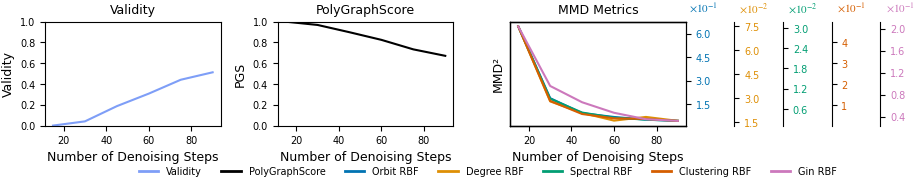

In [41]:
experiment = "model-quality/denoising-iterations"

results = pd.read_csv(
    f"/fs/pool/pool-mlsb/polygraph/{experiment}/results.csv"
)
display(results)

# Define MMD metrics to plot
mmd_metrics = ["orbit_mmd", "degree_mmd", "spectral_mmd", "clustering_mmd", "gin_mmd"]

# Create and save the plot using the new advanced plotting function
fig = plot_single_dataset_advanced(results, xlabel="Number of Denoising Steps")
fig.savefig(
    here() / ".local/plots" / f"{experiment.replace('/', '_')}_validity_polyscore_all_mmd.pdf",
    bbox_inches='tight'
)
plt.show()
plt.close(fig)

In [42]:
pgs_columns = ["num_steps", "validity", "polyscore", "orbit_pgs", "degree_pgs", "spectral_pgs", "clustering_pgs", "gin_pgs"]
pgs_df = results[pgs_columns]
header = ["\# Steps", "Validity", "PolyGraphScore", "Orbit PGS", "Degree PGS", "Spectral PGS", "Clustering PGS", "GIN PGS"]
formatters = [lambda x: x, lambda x: "\\formatpercent{"+str(x)+"}"] + [lambda x: "\\num[round-mode=places, round-precision=2]{"+str(x)+"}"] * 6
print(pgs_df.to_latex(columns=pgs_columns, index=False, header=header, formatters=formatters, column_format="l|cc|ccccc"))

\begin{tabular}{l|cc|ccccc}
\toprule
\# Steps & Validity & PolyGraphScore & Orbit PGS & Degree PGS & Spectral PGS & Clustering PGS & GIN PGS \\
\midrule
15 & \formatpercent{0.0} & \num[round-mode=places, round-precision=2]{0.9998915898930651} & \num[round-mode=places, round-precision=2]{0.9998915898930651} & \num[round-mode=places, round-precision=2]{0.687398903089308} & \num[round-mode=places, round-precision=2]{0.9925307239652263} & \num[round-mode=places, round-precision=2]{0.9994188517386228} & \num[round-mode=places, round-precision=2]{0.7863959399266955} \\
30 & \formatpercent{0.04052734375} & \num[round-mode=places, round-precision=2]{0.9683962029782184} & \num[round-mode=places, round-precision=2]{0.9683962029782184} & \num[round-mode=places, round-precision=2]{0.4314373107140501} & \num[round-mode=places, round-precision=2]{0.8016335766308356} & \num[round-mode=places, round-precision=2]{0.8989172110907925} & \num[round-mode=places, round-precision=2]{0.5679589397942207} \\
45

In [43]:
pgs_columns = ["num_steps", "validity", "orbit_mmd", "degree_mmd", "spectral_mmd", "clustering_mmd", "gin_mmd"]
pgs_df = results[pgs_columns]
header = ["\# Steps", "Validity", "Orbit RBF", "Degree RBF", "Spectral RBF", "Clustering RBF", "GIN RBF"]
formatters = [lambda x: x, lambda x: "\\formatpercent{"+str(x)+"}"] + [lambda x: "\\num[round-mode=places, round-precision=4]{"+str(x)+"}"] * 6
print(pgs_df.to_latex(columns=pgs_columns, index=False, header=header, formatters=formatters, column_format="l|c|ccccc"))

\begin{tabular}{l|c|ccccc}
\toprule
\# Steps & Validity & Orbit RBF & Degree RBF & Spectral RBF & Clustering RBF & GIN RBF \\
\midrule
15 & \formatpercent{0.0} & \num[round-mode=places, round-precision=4]{0.6459998934396883} & \num[round-mode=places, round-precision=4]{0.0750545421304689} & \num[round-mode=places, round-precision=4]{0.0304972167049322} & \num[round-mode=places, round-precision=4]{0.4750743269760304} & \num[round-mode=places, round-precision=4]{0.2041332719982833} \\
30 & \formatpercent{0.04052734375} & \num[round-mode=places, round-precision=4]{0.1878949737877178} & \num[round-mode=places, round-precision=4]{0.02798774991599} & \num[round-mode=places, round-precision=4]{0.0090351474001322} & \num[round-mode=places, round-precision=4]{0.1206222115196018} & \num[round-mode=places, round-precision=4]{0.0956237389583333} \\
45 & \formatpercent{0.18701171875} & \num[round-mode=places, round-precision=4]{0.0921115235100258} & \num[round-mode=places, round-precision=4]{0.0207

## Number of Training Epochs

/tmp/ipykernel_22638/98742188.py:175: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_margin)
/tmp/ipykernel_22638/98742188.py:177: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


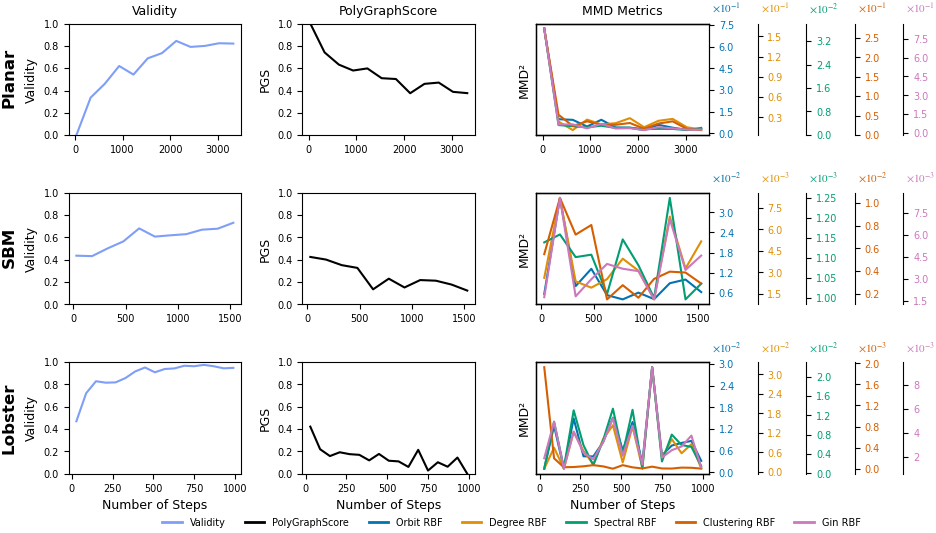

In [44]:

datasets = ["planar-procedural", "sbm-procedural", "lobster-procedural"]
datasets_labels = ["Planar", "SBM", "Lobster"]
datasets_data = []

for i, dataset in enumerate(datasets):
    experiment = f"/fs/pool/pool-mlsb/polygraph/digress-samples/{dataset}"
    results = pd.read_csv(f"{experiment}/results.csv")
    datasets_data.append(results)

fig = plot_multiple_datasets_advanced(datasets_data, datasets_labels)

plt.show()
fig.savefig(
    here() / ".local/plots" / f"all_training_epochs.pdf",
    bbox_inches='tight'
)
plt.close(fig)

In [45]:
import scipy.stats

# Function to compute correlations for each dataset
def compute_dataset_correlations():
    dataset_correlations = {}
    metric_names = ['validity', 'polyscore'] + mmd_metrics
    
    for i, dataset in enumerate(datasets):
        experiment = f"/fs/pool/pool-mlsb/polygraph/digress-samples/{dataset}"
        results = pd.read_csv(f"{experiment}/results.csv")
        
        correlations = {}
        for metric in metric_names:
            corr, _ = scipy.stats.spearmanr(results["num_steps"], results[metric])
            correlations[metric] = abs(corr)
        
        dataset_correlations[datasets_labels[i]] = correlations
    
    return dataset_correlations

# Compute correlations
dataset_correlations = compute_dataset_correlations()
dataset_correlations = pd.DataFrame(dataset_correlations)
dataset_correlations = dataset_correlations.transpose()

columns = ['validity', 'polyscore', 'orbit_mmd', 'degree_mmd', 'spectral_mmd', 'clustering_mmd', 'gin_mmd']
header = ["Validity", "PGS", "Orbit RBF", "Degree RBF", "Spectral RBF", "Clustering RBF", "GIN RBF"]
formatters = [lambda x: "\\formatpercent{"+str(x)+"}"] * 7
dataset_correlations = dataset_correlations[columns]

# Generate LaTeX table as before
print(dataset_correlations.to_latex(columns=columns, index=True, header=header, formatters=formatters, column_format="l|cc|ccccc"))

\begin{tabular}{l|cc|ccccc}
\toprule
 & Validity & PGS & Orbit RBF & Degree RBF & Spectral RBF & Clustering RBF & GIN RBF \\
\midrule
Planar & \formatpercent{0.9160839160839163} & \formatpercent{0.9160839160839163} & \formatpercent{0.8111888111888113} & \formatpercent{0.30069930069930073} & \formatpercent{0.8391608391608393} & \formatpercent{0.6573426573426573} & \formatpercent{0.7062937062937064} \\
SBM & \formatpercent{0.8545454545454546} & \formatpercent{0.8090909090909091} & \formatpercent{0.08181818181818183} & \formatpercent{0.22727272727272727} & \formatpercent{0.44545454545454555} & \formatpercent{0.5} & \formatpercent{0.24545454545454545} \\
Lobster & \formatpercent{0.8583692600503017} & \formatpercent{0.7426470588235294} & \formatpercent{0.13970588235294118} & \formatpercent{0.14215686274509806} & \formatpercent{0.06372549019607844} & \formatpercent{0.7107843137254903} & \formatpercent{0.004901960784313726} \\
\bottomrule
\end{tabular}

